# Chatpter 4 Implementing a GPT model from scratch to generate text

__Figure 4.1 The three main stages of coding an LLM. This chapter focuses on step 3 of stage 1: implementing the LLM architecture.__

![LLM architecture](https://drek4537l1klr.cloudfront.net/raschka/Figures/4-1.png)

## 4.1 Coding an LLM architecture

__Figure 4.2 A GPT model. In addition to the embedding layers, it consists of one or more transformer blocks containing the masked multi-head attention module we previously implemented.__

![a GPT model](https://drek4537l1klr.cloudfront.net/raschka/Figures/4-2.png)

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # vocabulary size
    "context_length": 1024, # context length
    "emb_dim": 1024,        # emnbedding dimension
    "n_heads": 12,          # number of attention heads
    "n_layers": 12,         # number of layers
    "drop_rate": 0.1,       # dropout rate
    "qkv_bias": False,      # use bias in qkv projection
}

__Figure 4.3 The order in which we code the GPT architecture. We start with the GPT backbone, a placeholder architecture, before getting to the individual core pieces and eventually assembling them in a transformer block for the final GPT architecture.__

![order of coding the GPT architecture](https://drek4537l1klr.cloudfront.net/raschka/Figures/4-3.png)

In [10]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
      return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalised_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

__Figure 4.4 A big-picture overview showing how the input data is tokenized, embedded, and fed to the GPT model. Note that in our `DummyGPTClass` coded earlier, the token embedding is handled inside the GPT model. In LLMs, the embedded input token dimension typically matches the output dimension. The output embeddings here represent the context vectors (see chapter 3).__

![data tokenisation](https://drek4537l1klr.cloudfront.net/raschka/Figures/4-4.png)

In [14]:
import tiktoken

tokeniser = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"

txt2 = "Every day holds a"

batch.append(torch.tensor(tokeniser.encode(txt1)))
print("txt1 tokenised:", tokeniser.encode(txt1))

batch.append(torch.tensor(tokeniser.encode(txt2)))
print("txt2 tokenised:", tokeniser.encode(txt2))

batch = torch.stack(batch, dim=0)

print(batch)

txt1 tokenised: [6109, 3626, 6100, 345]
txt2 tokenised: [6109, 1110, 6622, 257]
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [11]:
torch.manual_seed(123)

model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)

print("Output shape:", logits.shape)

print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3243,  0.2191,  0.1264,  ..., -0.0831,  0.3394,  0.8262],
         [ 0.8536,  0.7409, -0.4544,  ..., -0.8080, -1.0560,  1.8344],
         [ 0.6585, -0.0304,  1.4923,  ...,  1.4548, -0.5115, -0.8890],
         [-0.9717,  1.7165,  0.5372,  ...,  0.6975,  0.5431, -0.2599]],

        [[ 0.4888,  0.2158, -0.0769,  ...,  0.1971,  0.2417,  0.0826],
         [-0.3212,  0.4928,  0.6058,  ..., -0.9014, -0.1792, -0.4753],
         [ 0.6934,  1.3076,  1.4037,  ...,  1.3630,  1.3248, -0.4038],
         [-1.3500,  1.6508,  0.1928,  ...,  1.6955,  1.7293,  0.9035]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2 Normalising activations with layer normalisation

__Figure 4.5 An illustration of layer normalization where the six outputs of the layer, also called activations, are normalized such that they have a 0 mean and a variance of 1.__

![layer normalisation](https://drek4537l1klr.cloudfront.net/raschka/Figures/4-5.png)

In [15]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())

out = layer(batch_example)

print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [16]:
mean = out.mean(dim=-1, keepdim=True)

var = out.var(dim=-1, keepdim=True)

print("Mean:", mean)

print("Variance:", var)

Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


__Figure 4.6 An illustration of the dim parameter when calculating the mean of a tensor. For instance, if we have a two-dimensional tensor (matrix) with dimensions [rows, columns], using dim=0 will perform the operation across rows (vertically, as shown at the bottom), resulting in an output that aggregates the data for each column. Using dim=1 or dim=-1 will perform the operation across columns (horizontally, as shown at the top), resulting in an output aggregating the data for each row.__

![dim=-1 for normalisation](https://drek4537l1klr.cloudfront.net/raschka/Figures/4-6.png)

In [17]:
out_norm = (out - mean) / torch.sqrt(var)

mean = out_norm.mean(dim=-1, keepdim=True)

var = out_norm.var(dim=-1, keepdim=True)

print("Normalisated layer outputs:", out_norm)

print("Mean after normalisation:", mean)

print("Variance after normalisation:", var)

Normalisated layer outputs: tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean after normalisation: tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance after normalisation: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [18]:
torch.set_printoptions(sci_mode=False)

print("Mean after normalisation:", mean)

print("Variance after normalisation:", var)

Mean after normalisation: tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance after normalisation: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [20]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


In [21]:
ln = LayerNorm(emb_dim = 5)

out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)

var = out_ln.var(dim=-1, keepdim=True)

print("Mean after normalisation:", mean)

print("Variance after normalisation:", var)

Mean after normalisation: tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance after normalisation: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


__Figure 4.7 The building blocks necessary to build the GPT architecture. So far, we have completed the GPT backbone and layer normalization. Next, we will focus on GELU activation and the feed forward network.__

![covered first 2 bulding blocks](https://drek4537l1klr.cloudfront.net/raschka/Figures/4-7.png)

## 4.3 Implementing a fed forward network with GELU activations

![GELU](https://drek4537l1klr.cloudfront.net/raschka/Figures/Equation-eqs-4.png)

In [22]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
            )
        )

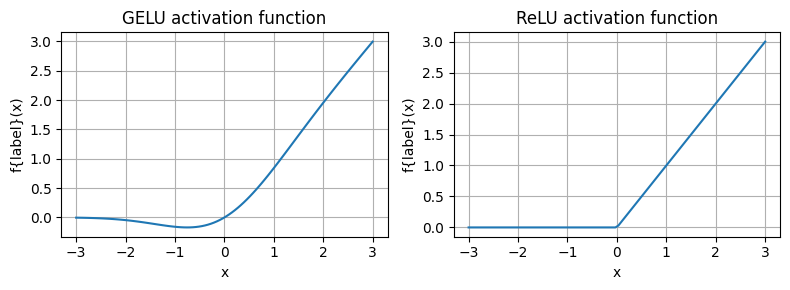

In [25]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)

y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel("f{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()